In [321]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from scipy.stats import skew,norm
import time
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-new-user/countries.csv
/kaggle/input/airbnb-new-user/sample_submission_NDGC_3.csv
/kaggle/input/airbnb-new-user/age_gender_bkts.csv
/kaggle/input/airbnb-new-user/train.csv
/kaggle/input/airbnb-new-user/test.csv
/kaggle/input/airbnb-new-user/sessions.csv


In [322]:
dataPathName="/kaggle/input/airbnb-new-user/";

In [323]:
class dataset:
    def __init__(self,pathname):
        self.trainDf=pd.read_csv(dataPathName+"train.csv");
        self.testDf=pd.read_csv(dataPathName+'test.csv');
        self.sessionsDf=pd.read_csv(dataPathName+'sessions.csv');
        self.countriesDf=pd.read_csv(dataPathName+'countries.csv');
        self.agesDistDf=pd.read_csv(dataPathName+'age_gender_bkts.csv');
        
        
    def printShapes(self):
        print(self.trainDf.shape);
        print(self.testDf.shape);
        print(self.sessionsDf.shape);
        print(self.countriesDf.shape);
        print(self.agesDistDf.shape);

In [324]:
class drawPlots:
    def __init__(self,dataset):
        self.dataset=dataset;
    
    def boxPlot(self,xAxis,yAxis,types):
        plt.subplots(figsize=(15,10));
        sns.boxplot(x=xAxis,y=yAxis,data=types);
        
        
    def distPlot(self,types,condition,variable):
        plt.subplots(figsize=(25,10));
        sns.distplot(types[condition][variable]);
        
    def distPlotNoCond(self,types,var):
        plt.subplots(figsize=(25,10));
        sns.distplot(types[var]);
    
    def countPlotWithHue(self,xAxis,hue,types):
        plt.subplots(figsize=(25,10));
        sns.countplot(types[xAxis],hue=types[hue]);
        
    def countPlotWithoutHue(self,xAxis,types):
        plt.subplots(figsize=(25,10));
        sns.countplot(types[xAxis]);
        
    def countPlotWithoutHueY(self,xAxis,types):
        plt.subplots(figsize=(25,10));
        sns.countplot(y=types[xAxis]);
    
        
    def catPlotWithHue(self,xAxis,yAxis,kind,hue,types):
        g=sns.catplot(x=xAxis,y=yAxis,kind=kind,hue=hue,data=types);
        g.fig.set_figwidth(25);
        g.fig.set_figheight(10);
        
    def catPlotWithoutHue(self,xAxis,yAxis,kind,types):
        g=sns.catplot(x=xAxis,y=yAxis,kind=kind,data=types);
        g.fig.set_figwidth(25);
        g.fig.set_figheight(10);

In [325]:
class preprocess:
    def __init__(self,dataset):
        self.trainDf=dataset.trainDf;
        self.testDf=dataset.testDf;
        self.sessionsDf=dataset.sessionsDf;
        self.countriesDf=dataset.countriesDf;
        self.agesDistDf=dataset.agesDistDf;
        
    def printNulls(self,types):
        for cols in types.columns:
            print(cols," ---->",types[cols].isnull().sum());
      
    def printNUNIQUE(self,types):
        for cols in types.columns:
            print(cols," -->",types[cols].nunique());
    
    def fillValsAge(self):
        self.agesDistDf['age_bucket']=self.agesDistDf['age_bucket'].apply(lambda x:'100-104' if x=='100+' else x)
        self.agesDistDf['meanAge']=self.agesDistDf['age_bucket'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 );
        
    def remove(self):
        self.agesDistDf.drop(['year'],axis=1,inplace=True);
       
    def fillValsSessions(self):
        self.sessionsDf['action'].replace('-unknown-',np.nan,inplace=True);
        self.sessionsDf['action_type'].replace('-unknown-',np.nan,inplace=True);
        self.sessionsDf['action_detail'].replace('-unknown-',np.nan,inplace=True);
        self.sessionsDf['device_type'].replace('-unknown-',np.nan,inplace=True);
        

In [326]:
class makeNewDataFrame:
    def __init__(self,dataset):
        self.trainDf=dataset.trainDf;
        self.testDf=dataset.testDf;
        self.countriesDf=dataset.countriesDf;
        self.MixDataFrame=None;
        
        
    def preprocess(self):
        countryPopularity=self.trainDf['country_destination'].value_counts();
        countryPopularity=pd.Series(countryPopularity);
        #countryPopularity.index=countriesDf['country_destination'];

        languageDistance=self.countriesDf['language_levenshtein_distance'];
        languageDistance=pd.Series(languageDistance);
        languageDistance.index=self.countriesDf['country_destination'];

        countryArea=self.countriesDf['destination_km2'];
        countryArea=pd.Series(countryArea);
        countryArea.index=self.countriesDf['country_destination'];
    
        countryDistance=self.countriesDf['distance_km'];
        countryDistance=pd.Series(countryDistance);
        countryDistance.index=self.countriesDf['country_destination'];
        
        
        self.MixDataFrame = pd.concat([countryPopularity, countryDistance, languageDistance, countryArea], axis=1);
        self.MixDataFrame.columns = ['totalVisits', 'distance_km', 'language', 'area'];
        self.MixDataFrame.drop('NDF')
    def printDataFrame(self):
        print(self.MixDataFrame)
        
    def printCorrelationMatrix(self):
        print(self.MixDataFrame.corr());
    
    def printCorrelationMatrixRemove(self):
        print(self.MixDataFrame.drop(['US','NDF','other']).corr());
        

In [327]:
class combineDataBase:
    def __init__(self,dataset):
        self.allData=pd.concat((dataset.trainDf,dataset.testDf),axis=0,ignore_index=True);
        self.allData.drop('country_destination',axis=1,inplace=True)
        
    def preprocess1(self,dataset):
        self.allData['gender'].replace('-unknown-',np.nan,inplace=True);
        
        indexLessThan10=self.allData[self.allData['age']<10].index
        indexGreatThan100=self.allData[self.allData['age']>100].index
        self.allData.loc[indexLessThan10,'age']=np.nan;
        self.allData.loc[indexGreatThan100,'age']=np.nan;
        
    def preprocess2(self,dataset):
        categoricalFeatureSet=[
          'gender',
          'signup_method',
          'language',
          'affiliate_channel',
          'affiliate_provider',
          'first_affiliate_tracked',
          'signup_app',
          'first_device_type',
          'first_browser'
        ]

        for cols in categoricalFeatureSet:
            self.allData[cols]=self.allData[cols].astype('category');

            self.allData['date_account_created']=pd.to_datetime(self.allData['date_account_created']);
            self.allData['date_first_booking']=pd.to_datetime(self.allData['date_first_booking']);
            self.allData['timestamp_first_active']=pd.to_datetime(self.allData['timestamp_first_active']);
            
    def preprocess3(self,dataset):
        dataset.trainDf['date_account_created']=pd.to_datetime(dataset.trainDf['date_account_created']);
        dataset.trainDf['timestamp_first_active']=pd.to_datetime(dataset.trainDf['timestamp_first_active']);
        dataset.trainDf['date_first_booking']=pd.to_datetime(dataset.trainDf['date_first_booking']);
        
    def preprocess4(self,dataset):
        dataset.trainDf['date_account_created']=pd.to_datetime(dataset.trainDf['date_account_created']);
        dataset.trainDf['timestamp_first_active']=pd.to_datetime(dataset.trainDf['timestamp_first_active']);
        dataset.trainDf['date_first_booking']=pd.to_datetime(dataset.trainDf['date_first_booking']);

        dataset.testDf['date_account_created']=pd.to_datetime(dataset.testDf['date_account_created']);
        dataset.testDf['timestamp_first_active']=pd.to_datetime(dataset.testDf['timestamp_first_active']);
        dataset.testDf['date_first_booking']=pd.to_datetime(dataset.testDf['date_first_booking']);

        self.allData['date_account_created']=pd.to_datetime(self.allData['date_account_created']);
        self.allData['timestamp_first_active']=pd.to_datetime(self.allData['timestamp_first_active']);
        self.allData['date_first_booking']=pd.to_datetime(self.allData['date_first_booking']);

        combine=[dataset.trainDf,dataset.testDf,self.allData]
        return combine
    
    def preprocess5(self,combine):
        dictValDay={
            0:'Monday',
            1:'Tuesday',
            2:'Wednesday',
            3:'Thursday',
            4:'Friday',
            5:'Saturday',
            6:'Sunday'
        }

        dictValMonth={
            1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sep',
            10:'Oct',
            11:'Nov',
            12:'Dec'
        }
        for dataset in combine:
            dataset['monthAccountCreated']=(dataset['date_account_created'].dt.month).map(dictValMonth);
            dataset['dayAccountCreated']=(dataset['date_account_created'].dt.dayofweek).map(dictValDay);
            dataset.drop(['timestamp_first_active'],axis=1,inplace=True)
            
        for dataset in combine:
            dataset['monthFirstBooking']=(dataset['date_first_booking'].dt.month).map(dictValMonth);
            dataset['dayFirstBooking']=(dataset['date_first_booking'].dt.dayofweek).map(dictValDay);
            
        for dataset in combine:
            dataset['date_first_booking'].fillna(1000);
            dataset.drop(['date_account_created'],axis=1,inplace=True)
            
        for dataset in combine:
            dataset.drop(['monthAccountCreated','dayAccountCreated','monthFirstBooking','dayFirstBooking'],axis=1,inplace=True);
            
            
    def preprocess6(self,dataset):
        dictVal={
            'NDF':12,
            'US':11,
            'other':10,
            'FR':9,
            'IT':8,
            'GB':7,
            'ES':6,
            'CA':5,
            'DE':4,
            'NL':3,
            'AU':2,
            'PT':1
        }
        dataset.trainDf['countryDestCodes']=dataset.trainDf['country_destination'].map(dictVal);
        dataset.trainDf.drop(['country_destination'],axis=1,inplace=True)
        
    def preprocess7(self,dataset):
        dataset.trainDf['first_affiliate_tracked'].fillna('Unknown',inplace=True);
        dataset.testDf['first_affiliate_tracked'].fillna('Unknown',inplace=True);

        dataset.trainDf['age'].fillna(dataset.trainDf['age'].mean(),inplace=True);
        dataset.testDf['age'].fillna(dataset.testDf['age'].mean(),inplace=True);
        
        dataset.trainDf.drop(['id'],axis=1,inplace=True)
        #ids=testDf['id']
        dataset.testDf.drop(['id'],axis=1,inplace=True)
        
    def preprocess8(self,dataset):
        answers=dataset.trainDf['countryDestCodes'];
        dataset.trainDf.drop(['countryDestCodes'],axis=1,inplace=True)
        return answers;
        
    def preprocess9(self,dataset):
        categoricalCols=[]
        for cols in dataset.trainDf.columns:
            if(dataset.trainDf[cols].dtypes=='object'):
                categoricalCols.append(cols);
        categoricalCols.append('gender');categoricalCols.append('signup_method');categoricalCols.append('signup_flow');
        return categoricalCols
            
        
    def preprocess10(self,combine,categoricalCols):
        for dataset in combine:
            for cols in categoricalCols:
                dataset[cols]=dataset[cols].replace('-unknown-','Unknown');
    
    
def ENCODING(dataset,categoricalCols,allData):
    
    allData=pd.concat((dataset.testDf,dataset.trainDf),axis=0,ignore_index=True);
    label_encoder = LabelEncoder()

    for cols in categoricalCols:
        if cols=='language':
            hello=pd.get_dummies(allData[cols],prefix='is_lang')
            allData.drop('language',axis=1,inplace=True);
            allData=pd.concat([allData,hello],axis=1);
            
            print("The shapes are ",dataset.trainDf.shape," ",dataset.testDf.shape);
            x=dataset.trainDf.shape[0]
            dataset.trainDf=allData[:x];
            dataset.testDf =allData[x:];
            print("The shapes are ",dataset.trainDf.shape," ",dataset.testDf.shape);
        else:
            label_encoder.fit(allData[cols]);
            dataset.trainDf[cols] = label_encoder.transform(dataset.trainDf[cols])
            dataset.testDf[cols]  = label_encoder.transform(dataset.testDf[cols]) 


In [328]:
def minMaxNorm(dataframe,col):
  return (dataframe[col]-dataframe[col].min())/(dataframe[col].max()-dataframe[col].min());

def standardScalar(dataframe,col):
  return (dataframe[col]-dataframe[col].mean())/dataframe[col].std();

In [329]:
def getCategoricalCols(dataset):
    categoricalCols=[];

    for cols in dataset.columns:
        if(dataset[cols].dtype=='object'):
            categoricalCols.append(cols);

    return categoricalCols

In [330]:
def getCommonProvider(dataset):
    g=dataset.trainDf[['affiliate_channel','affiliate_provider']].groupby('affiliate_provider').agg(lambda x:x.value_counts().index[0])
    print(g);
    
    
def analyzeDateAccount(dataset):
    dataset.allData['date_account_created'].value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
    dataset.allData['date_first_booking'].value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
    
    

def analyzeNDF(dataset):
    plt.subplots(figsize=(25,10))
    dataset.trainDf[dataset.trainDf['country_destination'] != 'NDF']['date_first_booking'].value_counts().plot(kind='line', linewidth=1, color='green')
    dataset.trainDf[dataset.trainDf['country_destination'] == 'NDF']['date_first_booking'].value_counts().plot(kind='line', linewidth=1, color='red')

In [331]:
class majorFeatureEngg:
    
    def affiliateProvider(self,df):
        commonAffiliateProvider=['direct','google','other'];
        df['affiliate_provider']=df['affiliate_provider'].apply(lambda x:'Rest' if x not in commonAffiliateProvider else x);
    
    def affiliateChannel(self,df):
        commonChannel=['direct','sem-brand','sem-non-brand'];
        df['affiliate_channel']=df['affiliate_channel'].apply(lambda x:'Rest' if x not in commonChannel else x);
    
    def language(self,df):
        languageList=['en','zh','fr','es','de','ko','it','ru','pt','ja','sv','nl']
        df['language']=df['language'].apply(lambda x:'Other' if x not in languageList else x);
        
    def signupMethod(self,df):
        lists=['basic','facebook'];
        df['signup_method']=df['signup_method'].apply(lambda x:'Other' if x not in lists else x);

    def signupApp(self,df):
        lists=['Web','iOS','Android'];
        df['signup_app']=df['signup_app'].apply(lambda x:'Other' if x not in lists else x);
    
    def deviceType(self,df):
        series=[]
        for rows in range(df.shape[0]):
            if(df.loc[rows,'first_device_type']=='Mac Desktop' or df.loc[rows,'first_device_type']=='Windows Desktop' or df.loc[rows,'first_device_type']=='Desktop (Other)'):
                series.append('Desktop');
            elif(df.loc[rows,'first_device_type']=='iPhone' or df.loc[rows,'first_device_type']=='iPad'or df.loc[rows,'first_device_type']=='Android Phone'):
                series.append('Phone');
            elif(df.loc[rows,'first_device_type']=='Android Tablet'):
                series.append('Tablet');
            else:
                series.append('Other');
        series=pd.Series(series);
        df['device_type_used']=series
    

    def deviceCompanyName(self,df):
        series=[]
        for rows in range(df.shape[0]):
            if(df.loc[rows,'first_device_type']=='Mac Desktop' or df.loc[rows,'first_device_type']=='iPad' or df.loc[rows,'first_device_type']=='iPhone'):
                series.append('Apple');
            else:
                series.append('Other');
        series=pd.Series(series);
        df['device_company_name']=series;

    def browsers(self,df):
        commonBrowsers=['Chrome','IE','Firefox','Safari','Mobile Safari'];
        df['first_browser']=df['first_browser'].apply(lambda x:'Other' if x not in commonBrowsers else x);
        
    def signupFlow(self,df):
        df['signup_flow']=df['signup_flow'].apply(lambda x:'Less Effort' if x<=3 else 'More Effort')
        
        


In [332]:
def featureEngineering(obj,df):
    obj.affiliateProvider(df);
    obj.affiliateChannel(df);
    obj.language(df);
    obj.signupMethod(df);
    obj.signupApp(df);
    obj.browsers(df);
    obj.deviceType(df);
    obj.deviceCompanyName(df);
    obj.signupFlow(df);

In [333]:
    print("LET US FIRST IMPORT ALL THE DATAFRAMES")
    dataset=dataset(dataPathName);
    
    #We create a drawPlots object so that we can call all the functions to draw the plots
    d1=drawPlots(dataset);
    
    print("LET US BRIEFLY ANALYZE ALL THE .csv FILES GIVEN")

LET US FIRST IMPORT ALL THE DATAFRAMES
LET US BRIEFLY ANALYZE ALL THE .csv FILES GIVEN


Let us analyze ages.csv FILE
This file has info about people who reside in the countries given
Let us see the ages of people in the given countries
We see that it follows similar to gaussian distribution with Male population more than females till age 50-54 and then women live longer


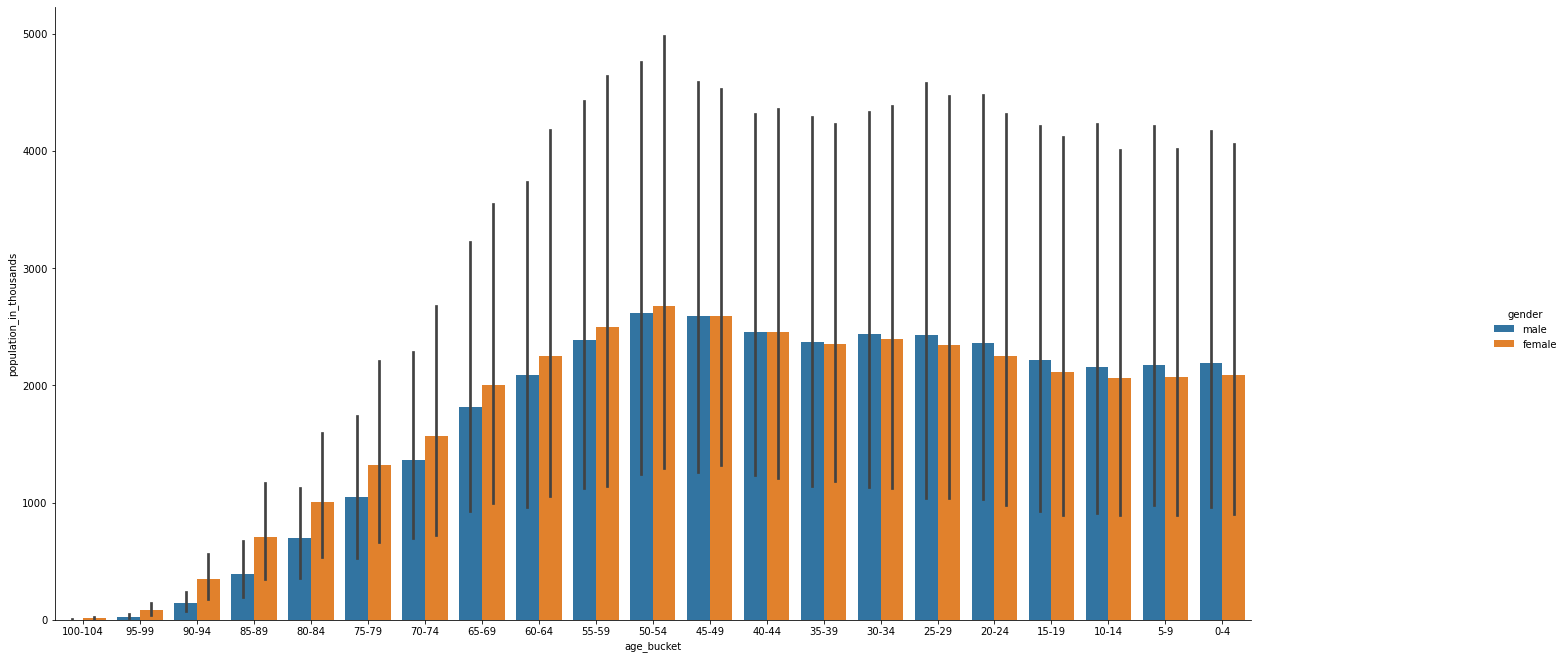

In [334]:
    print("Let us analyze ages.csv FILE")
    print("This file has info about people who reside in the countries given")
    p1=preprocess(dataset);
    p1.fillValsAge();
    print("Let us see the ages of people in the given countries")
    d1.catPlotWithHue('age_bucket','population_in_thousands','bar','gender',dataset.agesDistDf);
    print("We see that it follows similar to gaussian distribution with Male population more than females till age 50-54 and then women live longer");

Let us see the population of people in various country destinations
We see that US is most populated followed by Germany and the least populated country is portugal


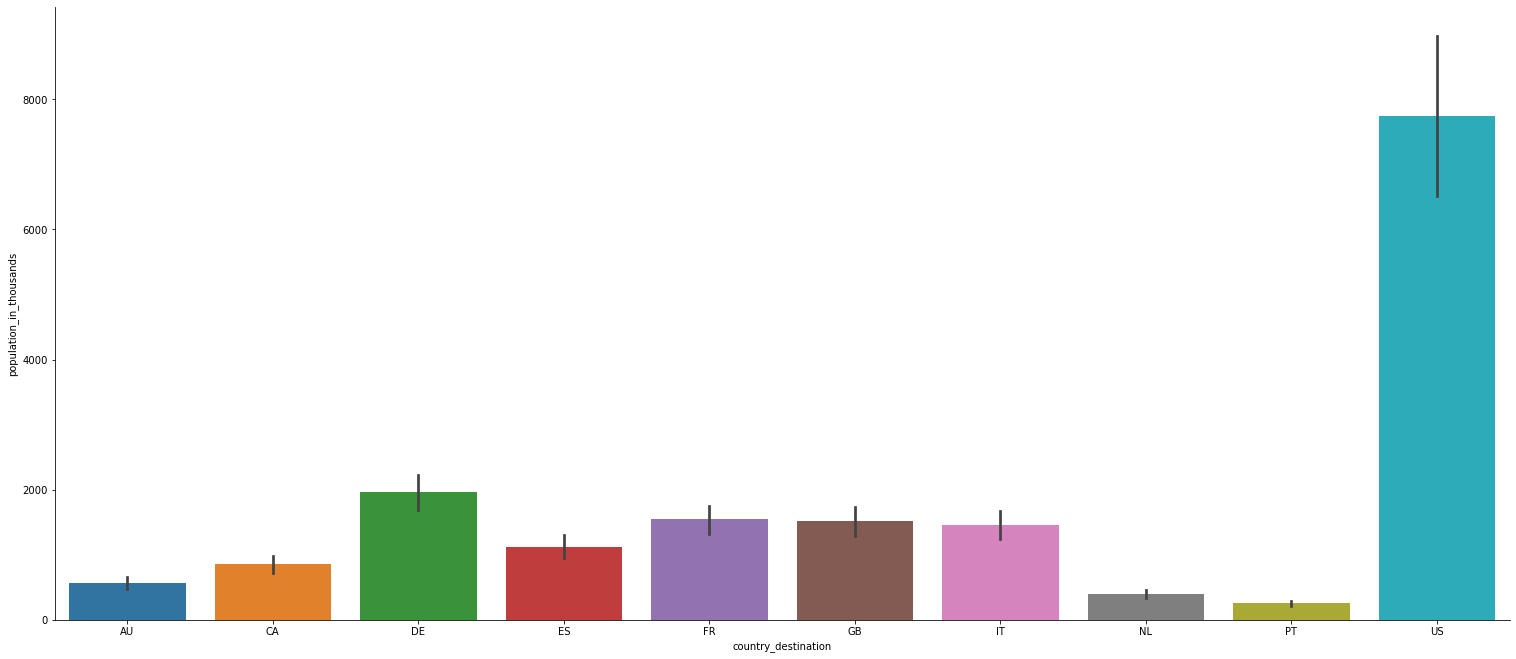

In [335]:
    print("Let us see the population of people in various country destinations")
    d1.catPlotWithoutHue('country_destination','population_in_thousands','bar',dataset.agesDistDf);
    print("We see that US is most populated followed by Germany and the least populated country is portugal");

Now let us analyze countries.csv file
Let us see the distance of given countries from USA
We see that Australia is farthest from USA and Canada is nearest to USA


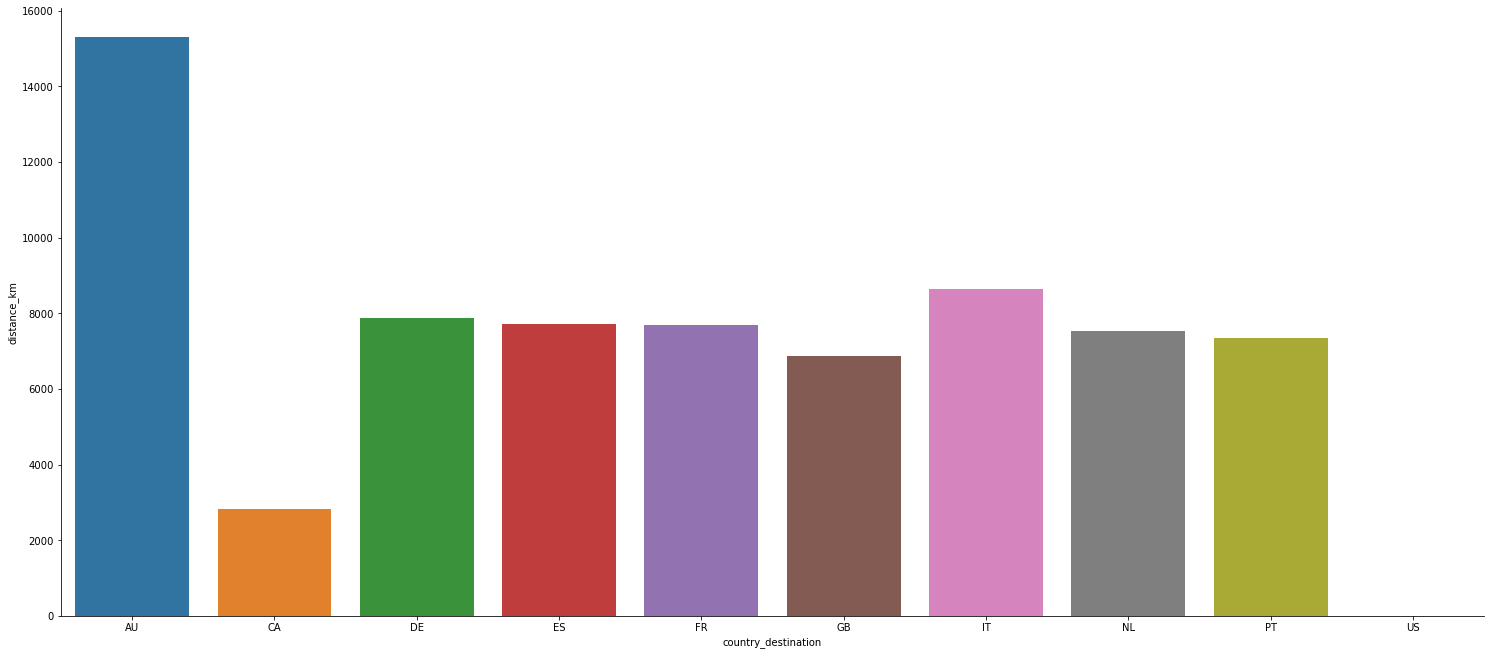

In [336]:
    print("Now let us analyze countries.csv file")
    print("Let us see the distance of given countries from USA");
    d1.catPlotWithoutHue('country_destination','distance_km','bar',dataset.countriesDf);
    print("We see that Australia is farthest from USA and Canada is nearest to USA");

Now let us compare the language distance from US to other countries ie. similarity of language in other countries compared to english
We see that portugal is farthest in terms of language distance followed by other european countries except United Kingdom


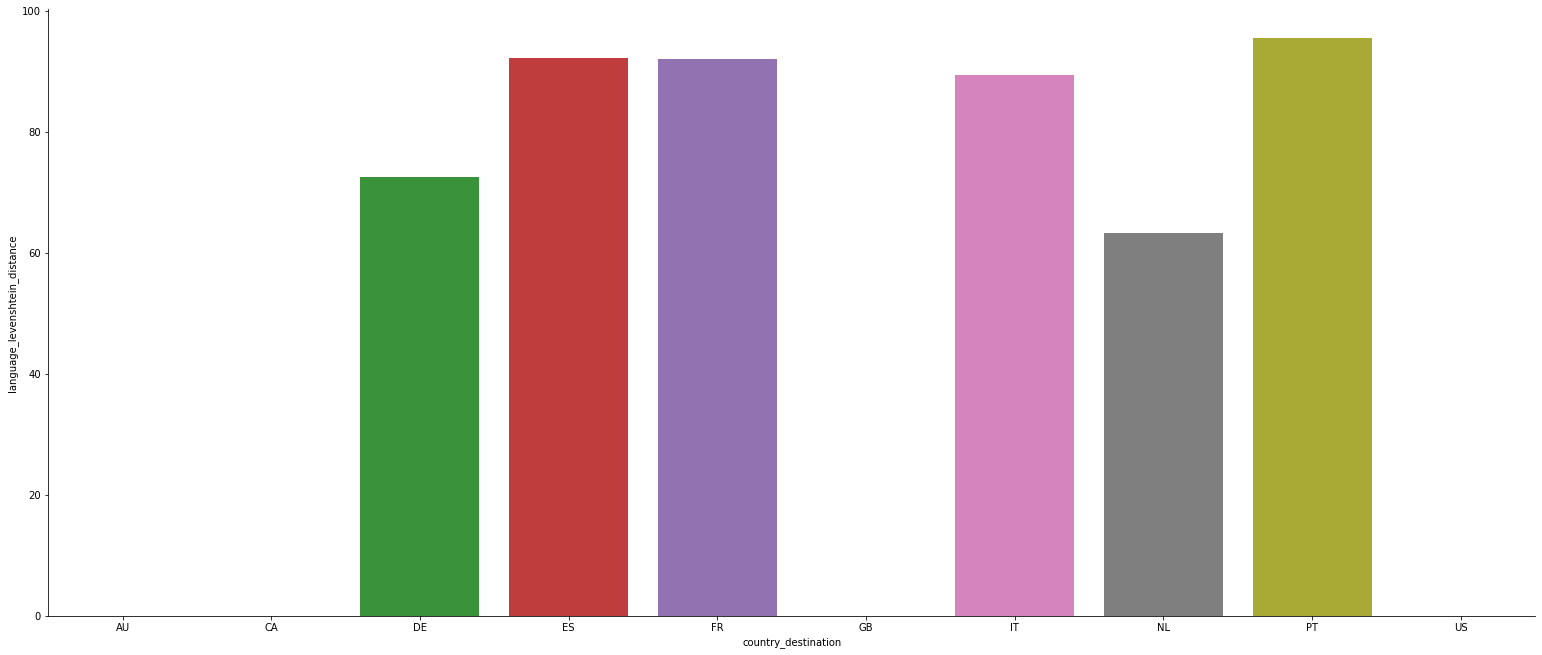

In [337]:
    print("Now let us compare the language distance from US to other countries ie. similarity of language in other countries compared to english");
    d1.catPlotWithoutHue('country_destination','language_levenshtein_distance','bar',dataset.countriesDf);
    print("We see that portugal is farthest in terms of language distance followed by other european countries except United Kingdom");

Let us see the area of each country
We see that Canada is the biggest country in terms of area followed by US and Australia


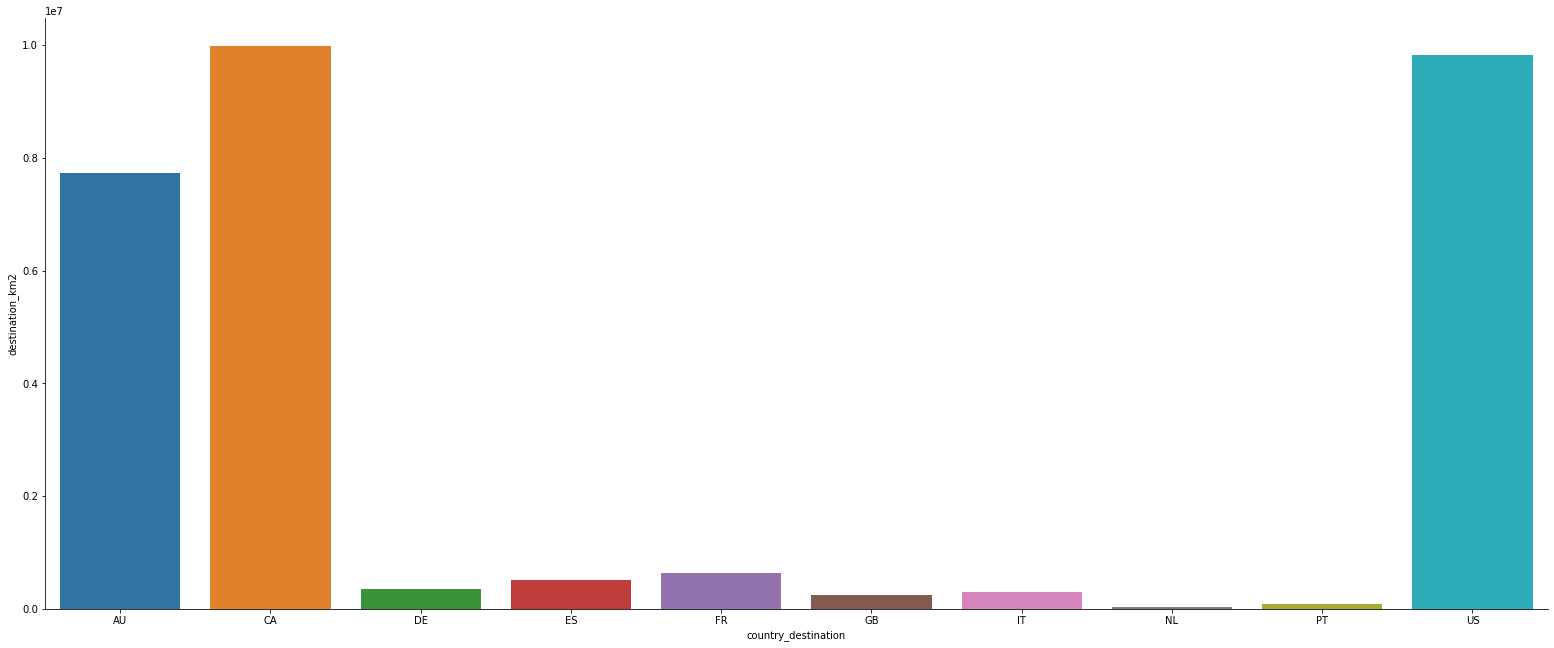

In [338]:
    print("Let us see the area of each country")
    d1.catPlotWithoutHue('country_destination','destination_km2','bar',dataset.countriesDf);
    print("We see that Canada is the biggest country in terms of area followed by US and Australia");

Let us see the most preferred countries by users of USA ie. which country did the users book more
We see that most users just explored the site and didn't book as NDF takes the first spot.Apart from NDF.....
We see that US takes the first spot(people preferred travelling in their own country) followed by other and France


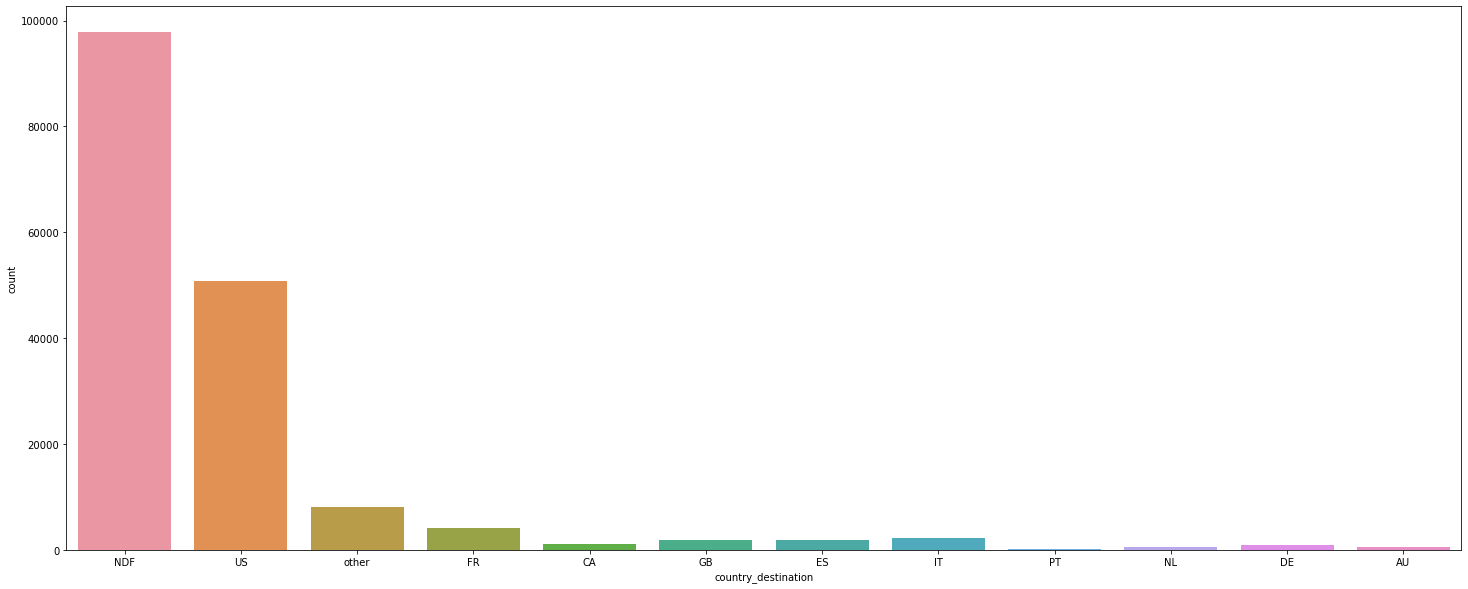

In [339]:
    print("Let us see the most preferred countries by users of USA ie. which country did the users book more");
    d1.countPlotWithoutHue('country_destination',dataset.trainDf);
    print("We see that most users just explored the site and didn't book as NDF takes the first spot.Apart from NDF.....")
    print("We see that US takes the first spot(people preferred travelling in their own country) followed by other and France");

In [340]:
    print("Let us make a new dataframe to get more insights")
    newDf=makeNewDataFrame(dataset);
    newDf.preprocess();
    newDf.printCorrelationMatrix();
    print("We see that ")
    print("We see that as distance from US increases , the totalVisits to that country decreases.");
    print("Also as language distance increases, the totalVisits to that country decreases.");
    print("Area shows positive correlation with totalVisits");

Let us make a new dataframe to get more insights
             totalVisits  distance_km  language      area
totalVisits     1.000000    -0.647796 -0.377789  0.538672
distance_km    -0.647796     1.000000  0.199798 -0.325407
language       -0.377789     0.199798  1.000000 -0.767175
area            0.538672    -0.325407 -0.767175  1.000000
We see that 
We see that as distance from US increases , the totalVisits to that country decreases.
Also as language distance increases, the totalVisits to that country decreases.
Area shows positive correlation with totalVisits


In [341]:
    newDf.printCorrelationMatrixRemove();
    print("BUT-------->>>>");
    print("When we drop home country i.e. US");
    print("We see that when language Distance increases...people tend to go there. People Prefer to go to EUROPE when going out of country");
    print("Also as area of country decreases..people tend to go there");

             totalVisits  distance_km  language      area
totalVisits     1.000000    -0.162914  0.286717 -0.259026
distance_km    -0.162914     1.000000 -0.078441  0.048063
language        0.286717    -0.078441  1.000000 -0.715772
area           -0.259026     0.048063 -0.715772  1.000000
BUT-------->>>>
When we drop home country i.e. US
We see that when language Distance increases...people tend to go there. People Prefer to go to EUROPE when going out of country
Also as area of country decreases..people tend to go there


Let us now analyze sessions.csv file
Let us see the activeness of users on the site
The median and avg. time elapsed is  1147.0 19405.81075070559
We see that Median and mean differ a lot....this means the dataset is filled with outliers
The min time is  0.0  and max time is  1799977.0


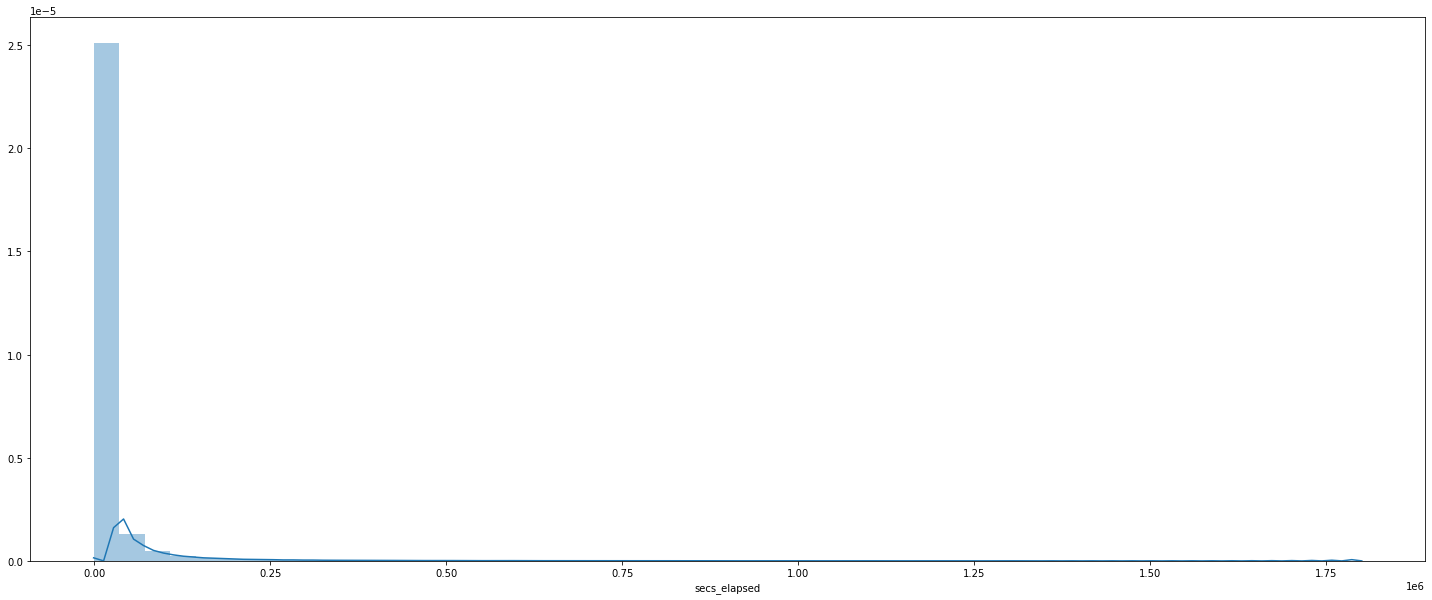

In [342]:
    p1.fillValsSessions();
    print("Let us now analyze sessions.csv file");
    print("Let us see the activeness of users on the site");
    d1.distPlot(dataset.sessionsDf,dataset.sessionsDf['secs_elapsed'].notnull(),'secs_elapsed');
    print("The median and avg. time elapsed is ",dataset.sessionsDf['secs_elapsed'].median(),dataset.sessionsDf['secs_elapsed'].mean())
    print("We see that Median and mean differ a lot....this means the dataset is filled with outliers");
    print("The min time is ",dataset.sessionsDf['secs_elapsed'].min()," and max time is ",dataset.sessionsDf['secs_elapsed'].max());

Let us analyze the device type used by users
We can see that Desktop is used more and then Phones.Also Apple users are more in case of Desktop and phones


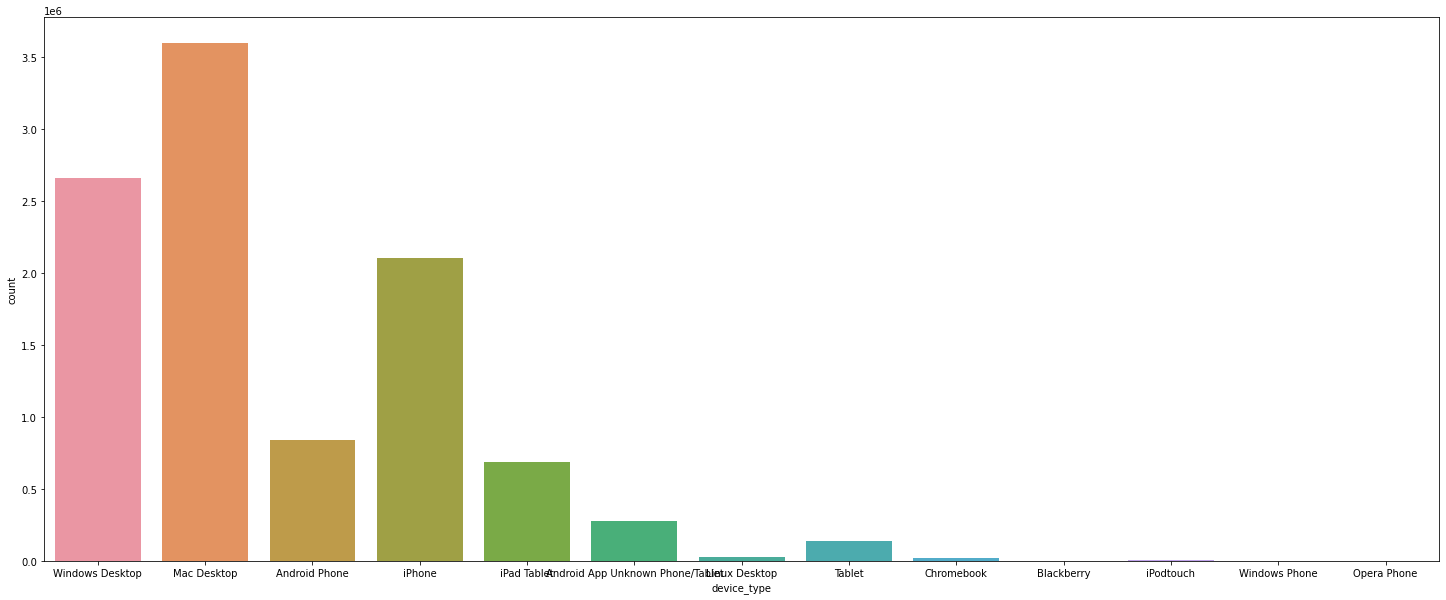

In [343]:
    print("Let us analyze the device type used by users");
    d1.countPlotWithoutHue('device_type',dataset.sessionsDf);
    print("We can see that Desktop is used more and then Phones.Also Apple users are more in case of Desktop and phones");

Let us see the language spoken by most users who prefer different countries
We see that English dominates in all countries of destination


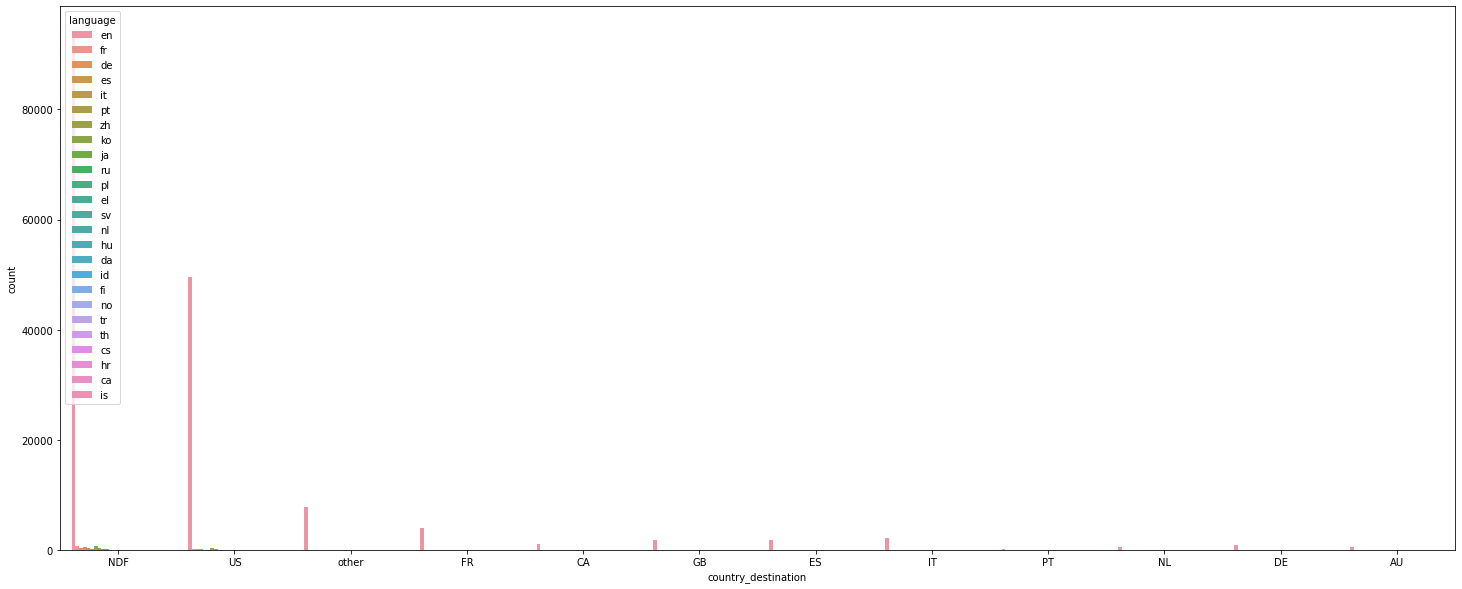

In [344]:
    print("Let us see the language spoken by most users who prefer different countries");
    d1.countPlotWithHue('country_destination','language',dataset.trainDf);
    print("We see that English dominates in all countries of destination");

Let us see the distribution of ages in both sets
We see some outliers in age....I converted those values to np.nan


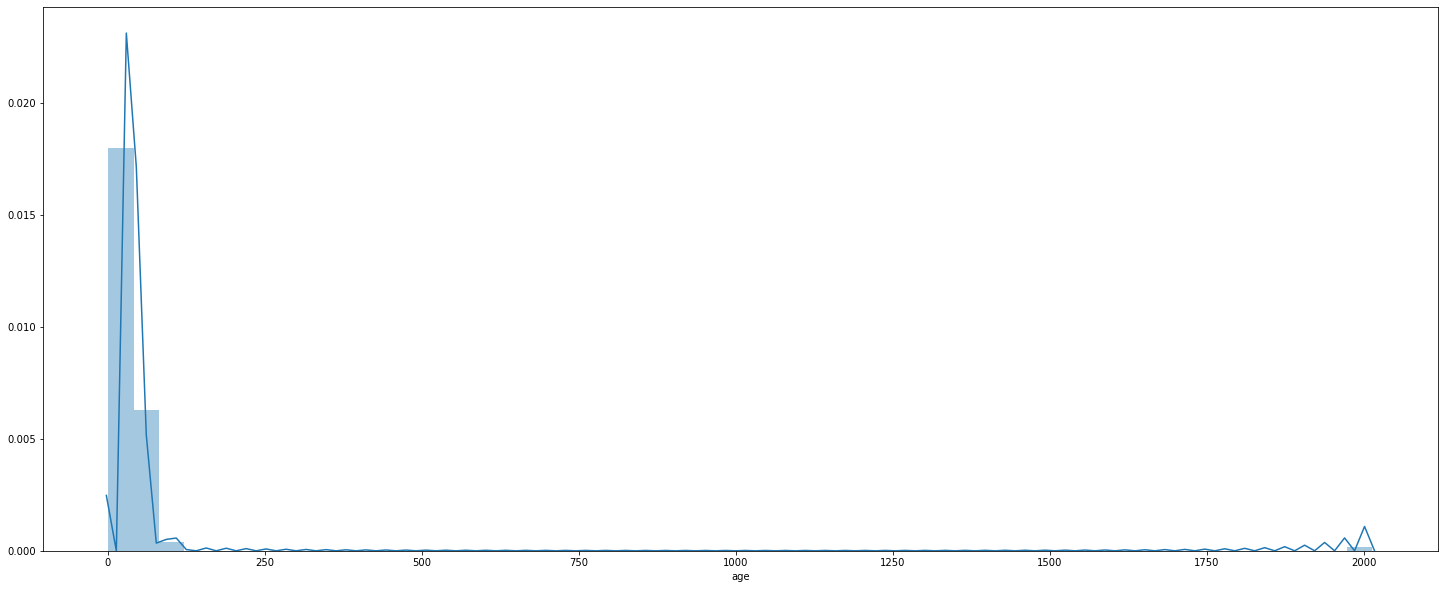

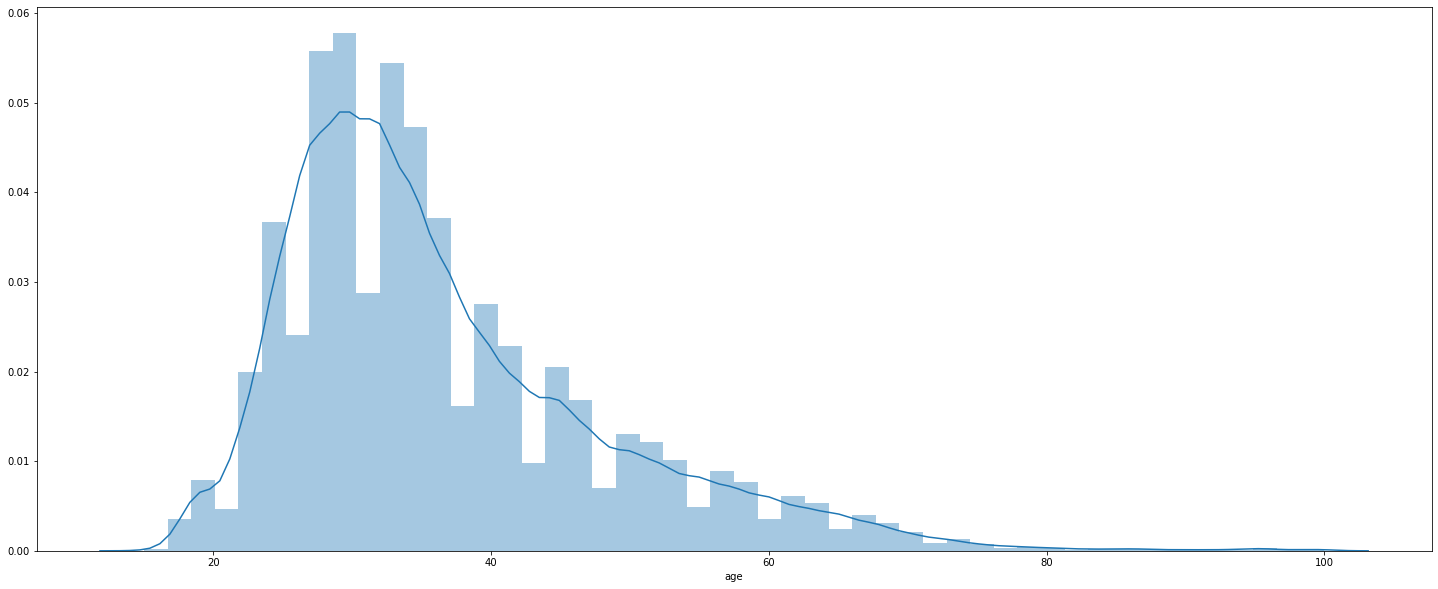

In [345]:
    combineDB=combineDataBase(dataset);
    print("Let us see the distribution of ages in both sets");
    d1.distPlotNoCond(combineDB.allData,'age');
    print("We see some outliers in age....I converted those values to np.nan");
    combineDB.preprocess1(dataset);
    d1.distPlotNoCond(combineDB.allData,'age');

In [346]:
categoricalColumns=getCategoricalCols(combineDB.allData);
combineDB.preprocess2(dataset);

Let us see the gender participation
We see that after -unknown- , more females have registered for Airbnb than males


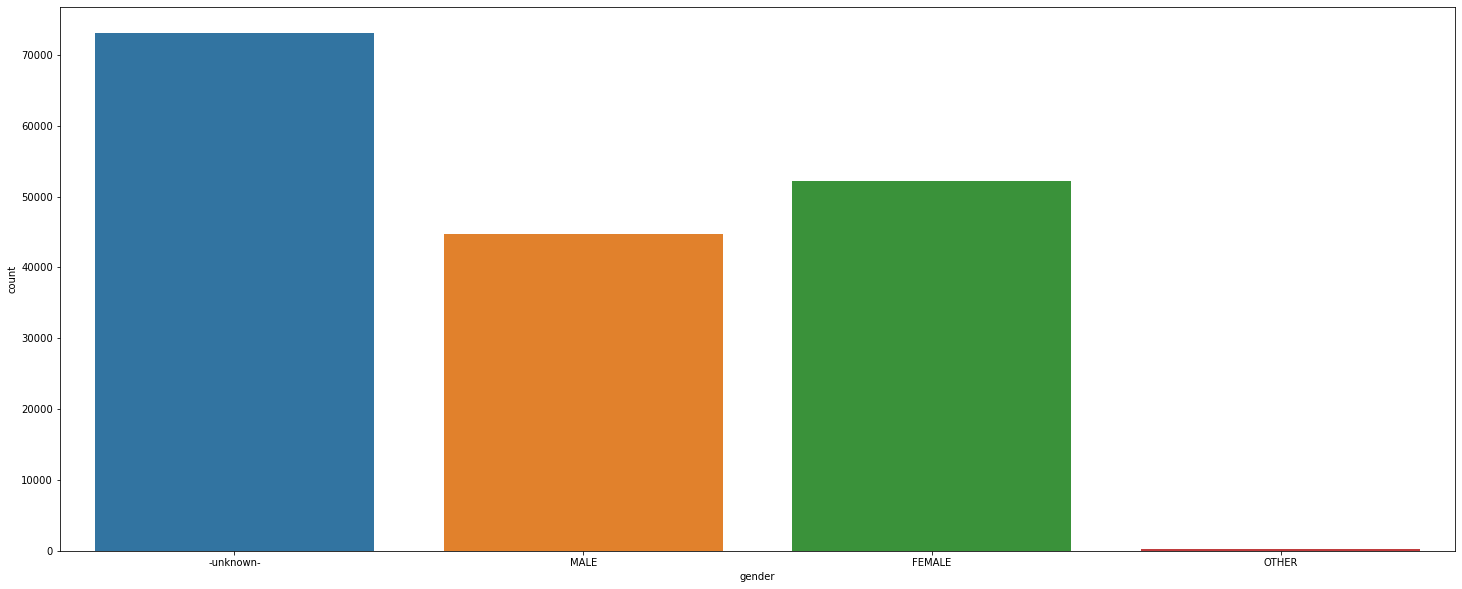

In [347]:
    print("Let us see the gender participation");
    d1.countPlotWithoutHue("gender",dataset.trainDf);
    print("We see that after -unknown- , more females have registered for Airbnb than males");

Let us see the signup_method used by users
We see that basic is the most preferred sign_up method and then FB


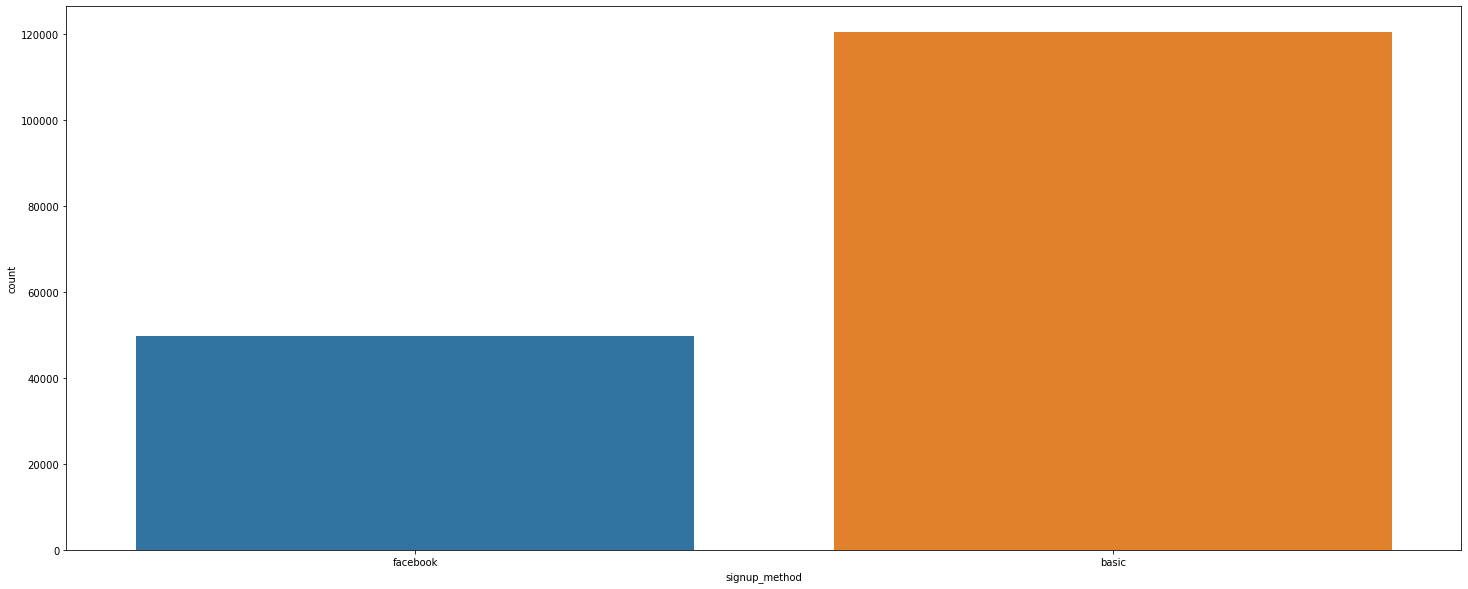

In [348]:
    print("Let us see the signup_method used by users");
    d1.countPlotWithoutHue("signup_method",dataset.trainDf);
    print("We see that basic is the most preferred sign_up method and then FB");
    

Also in the testDf we have google as signup_method which is least preferred


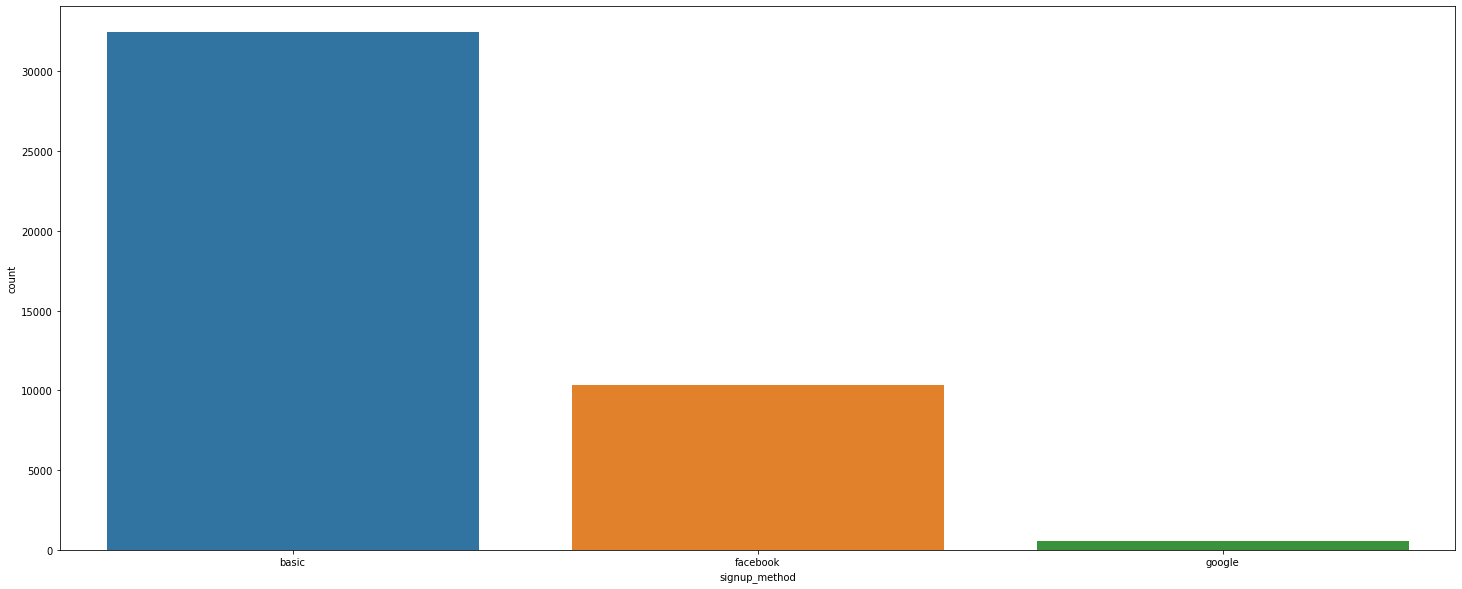

In [349]:
d1.countPlotWithoutHue("signup_method",dataset.testDf);
print("Also in the testDf we have google as signup_method which is least preferred")

Let us explore on signup app used by users
We see that Web is most preferred for signup and then comes iOS and then Android and Moweb


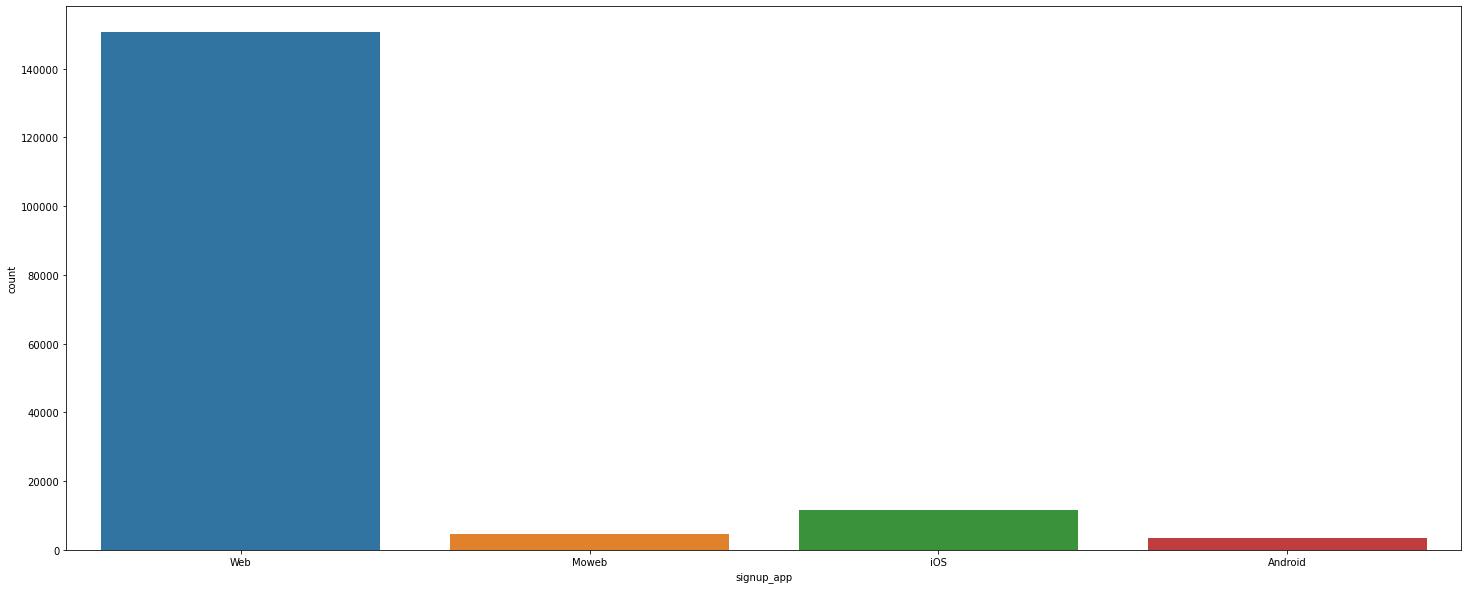

In [350]:
    print("Let us explore on signup app used by users");
    d1.countPlotWithoutHue("signup_app",dataset.trainDf);
    print("We see that Web is most preferred for signup and then comes iOS and then Android and Moweb");

Let us analyze the most common browsers used
We can see the most popular browsers used. Later we will do feature engineering to only keep most common browsers and replace others by 'Rest'


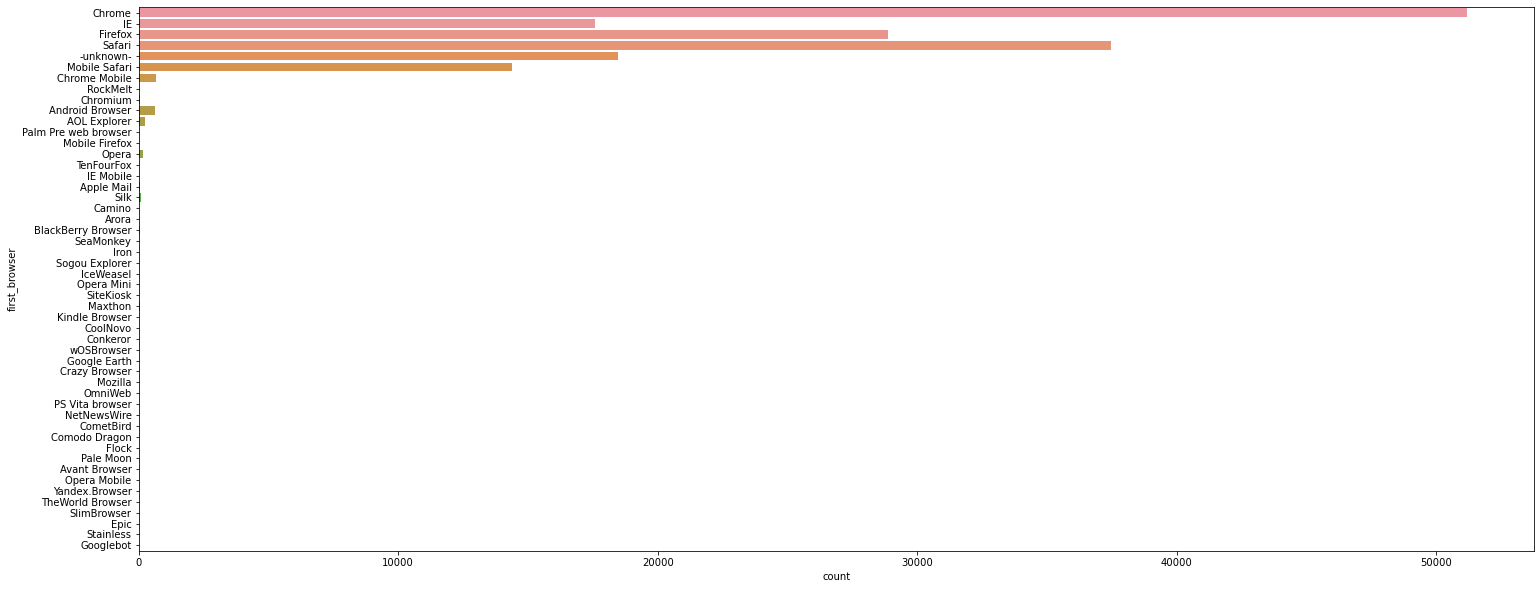

In [351]:
    print("Let us analyze the most common browsers used");
    d1.countPlotWithoutHueY("first_browser",dataset.trainDf);
    print("We can see the most popular browsers used. Later we will do feature engineering to only keep most common browsers and replace others by 'Rest'");

Let us see the first device type used by users during booking
We see that Desktop is most preferred(Mac more that Windows).Then comes iPhone and iPad


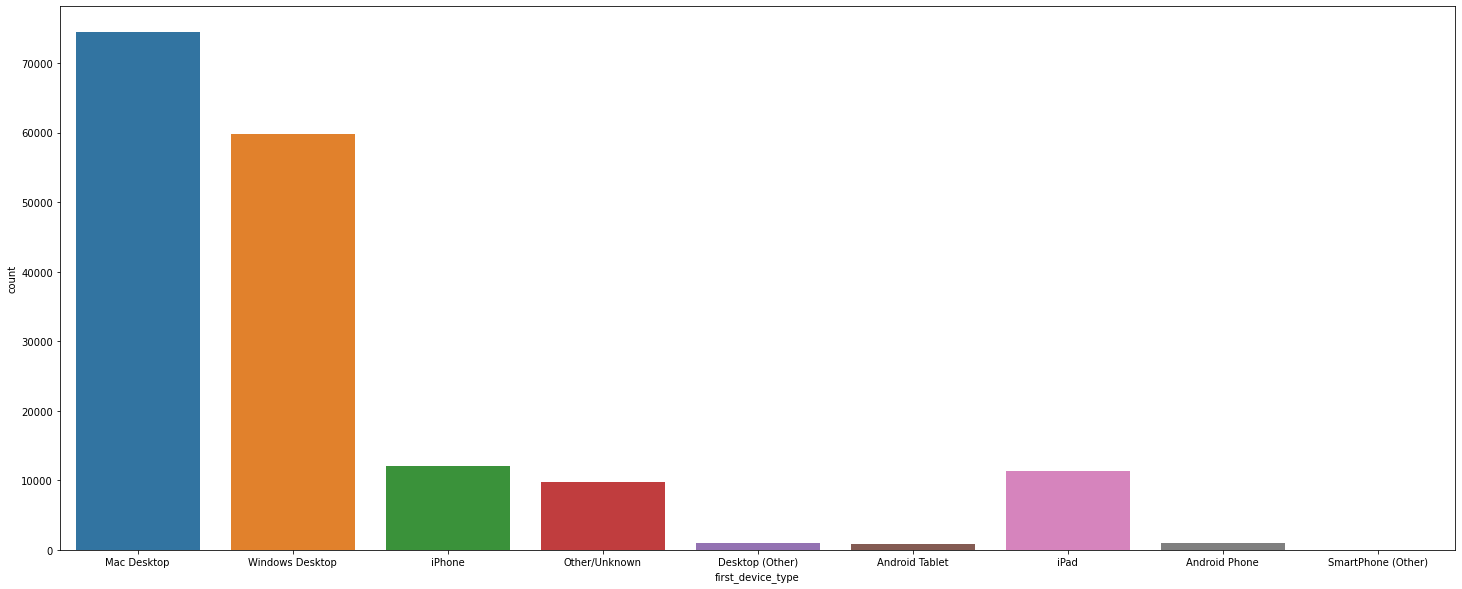

In [352]:
    print("Let us see the first device type used by users during booking");
    d1.countPlotWithoutHue("first_device_type",dataset.trainDf);
    print("We see that Desktop is most preferred(Mac more that Windows).Then comes iPhone and iPad")

We see that direct is the most common affiliate_channel


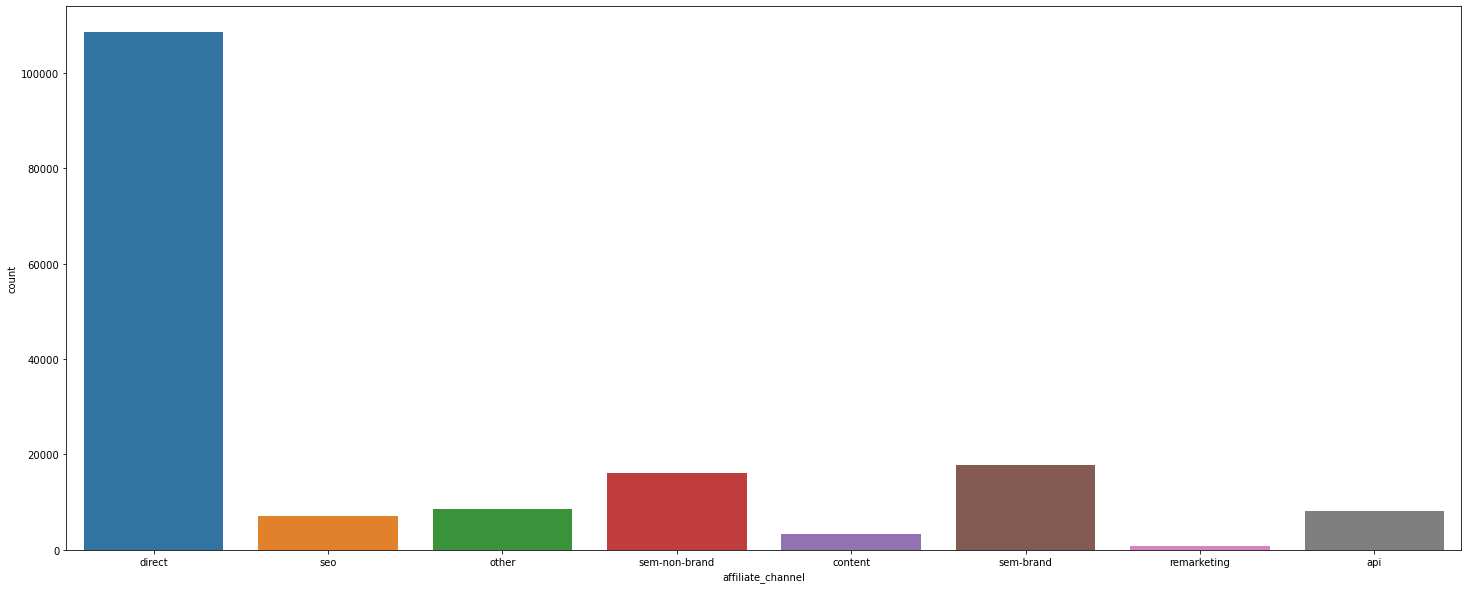

In [353]:
print("We see that direct is the most common affiliate_channel");
d1.countPlotWithoutHue("affiliate_channel",dataset.trainDf);

We also see that direct is the most common provider and then comes google.


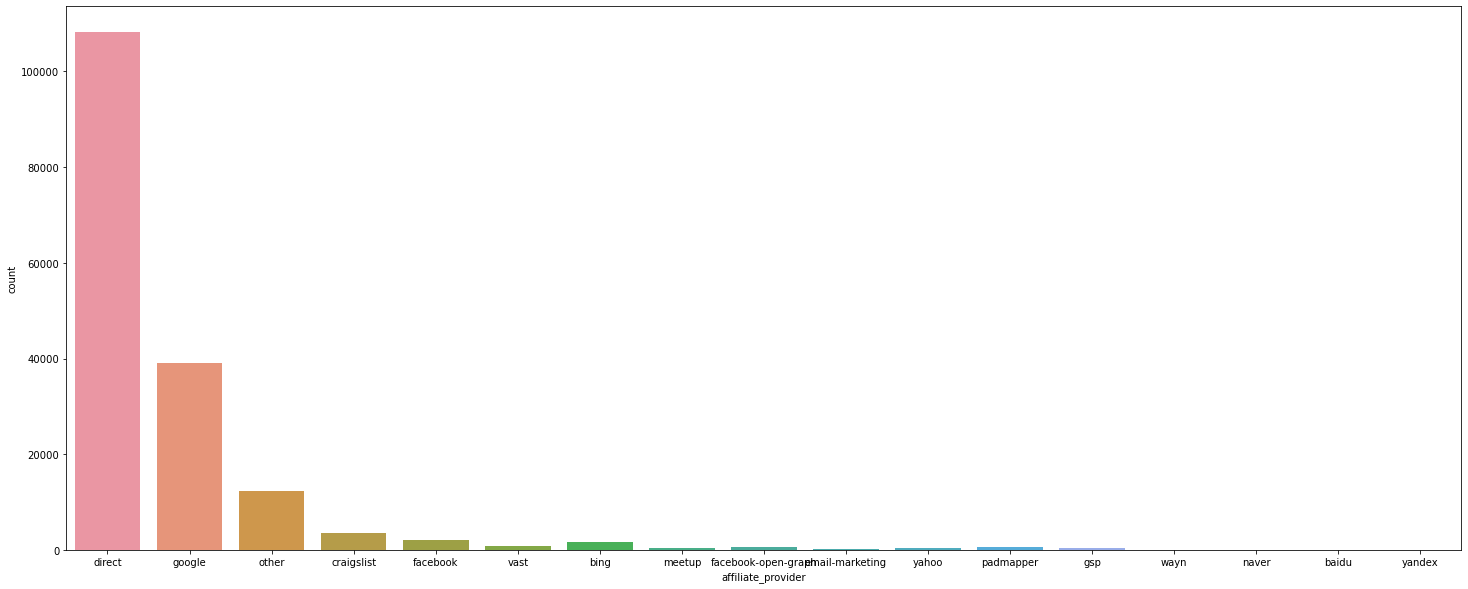

In [354]:
print("We also see that direct is the most common provider and then comes google.");
d1.countPlotWithoutHue("affiliate_provider",dataset.trainDf);

In [355]:
    print("Now let us group the affiliate channel and provider to get a dataframe and analyze");
    print("Now we see the most common channel used by various affiliate_providers");
    getCommonProvider(dataset);
    

Now let us group the affiliate channel and provider to get a dataframe and analyze
Now we see the most common channel used by various affiliate_providers
                    affiliate_channel
affiliate_provider                   
baidu                   sem-non-brand
bing                    sem-non-brand
craigslist                      other
direct                         direct
email-marketing                 other
facebook                          seo
facebook-open-graph             other
google                      sem-brand
gsp                           content
meetup                          other
naver                   sem-non-brand
other                             api
padmapper                       other
vast                    sem-non-brand
wayn                            other
yahoo                             seo
yandex                      sem-brand


Age Distribution is almost similar for all countries.
It seems like Spain is preferred most by younger people
Also United Kingdom is preferred most by older people


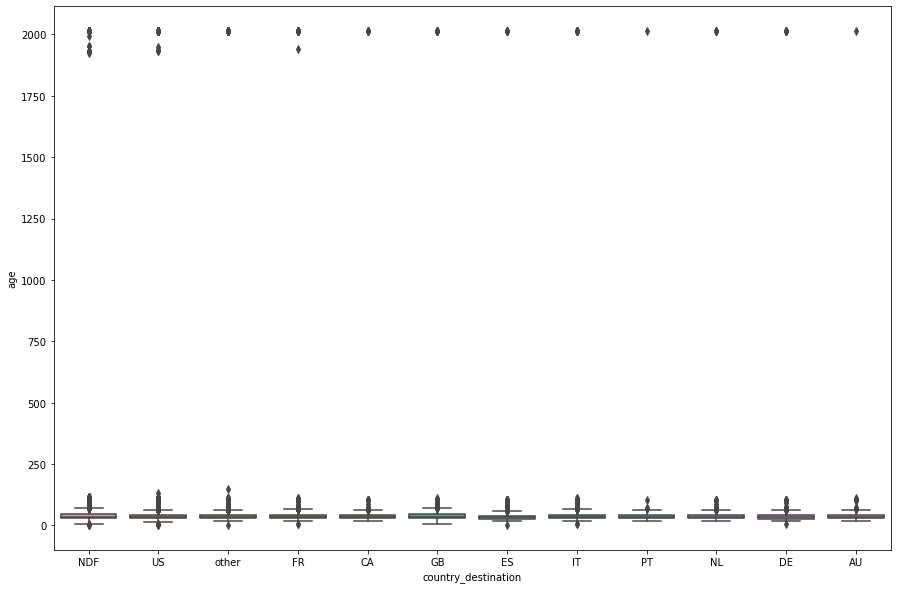

In [356]:
    print("Age Distribution is almost similar for all countries.");
    print("It seems like Spain is preferred most by younger people");
    print("Also United Kingdom is preferred most by older people");
    d1.boxPlot('country_destination','age',dataset.trainDf);

Let us understand gender bias among country destination
We can see that only for Germany,Canada and 'Other', Males prefer them more over females


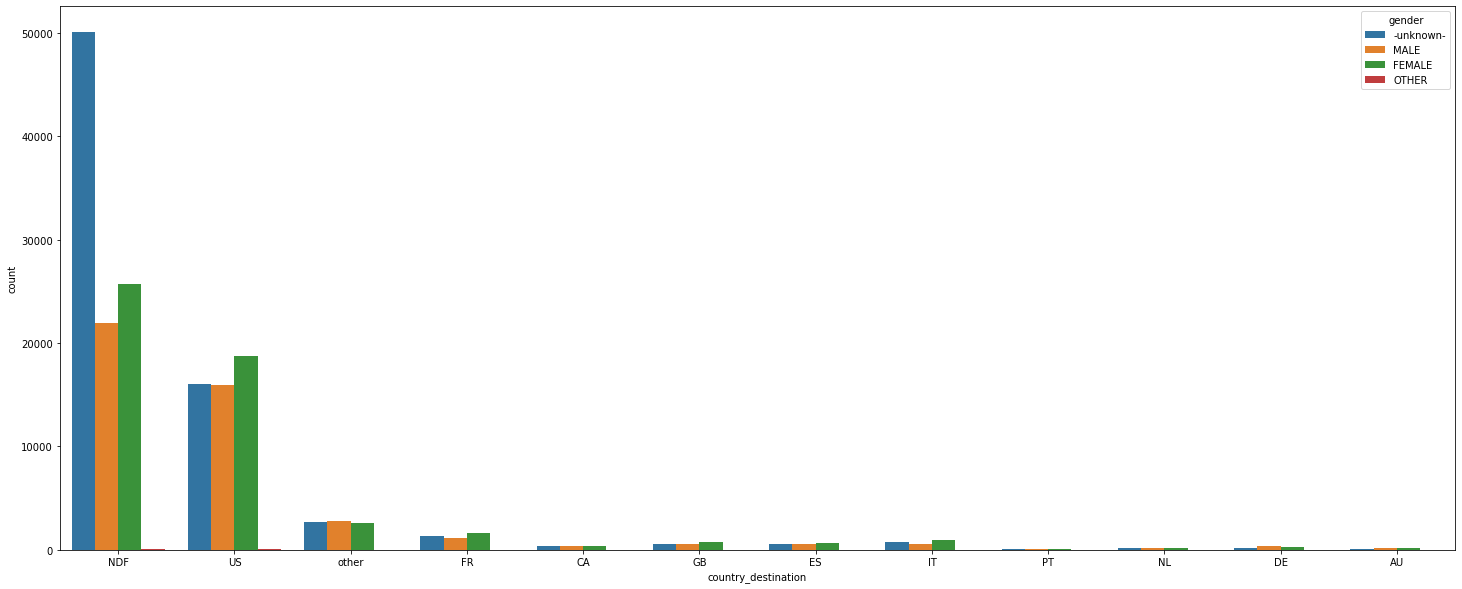

In [357]:
    print("Let us understand gender bias among country destination");
    print("We can see that only for Germany,Canada and 'Other', Males prefer them more over females");
    d1.countPlotWithHue("country_destination",'gender',dataset.trainDf);

We see that for users...most of them only viewed


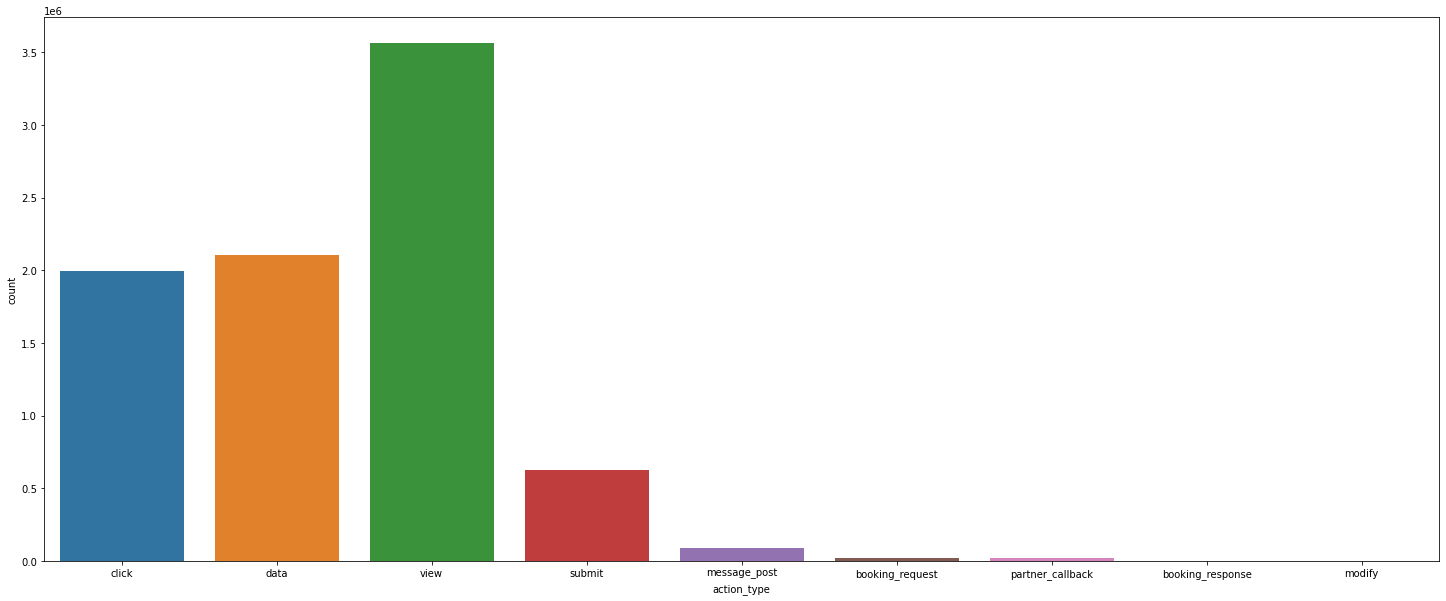

In [358]:
    print("We see that for users...most of them only viewed");
    d1.countPlotWithoutHue("action_type",dataset.sessionsDf);

Now lets analyze the Account creation column


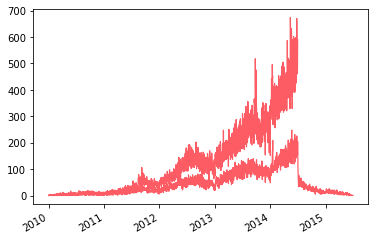

In [359]:
    print("Now lets analyze the Account creation column")
    combineDB.allData['date_account_created'].value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
    combineDB.allData['date_first_booking'].value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

There is no bias between signup_method and countryDestination


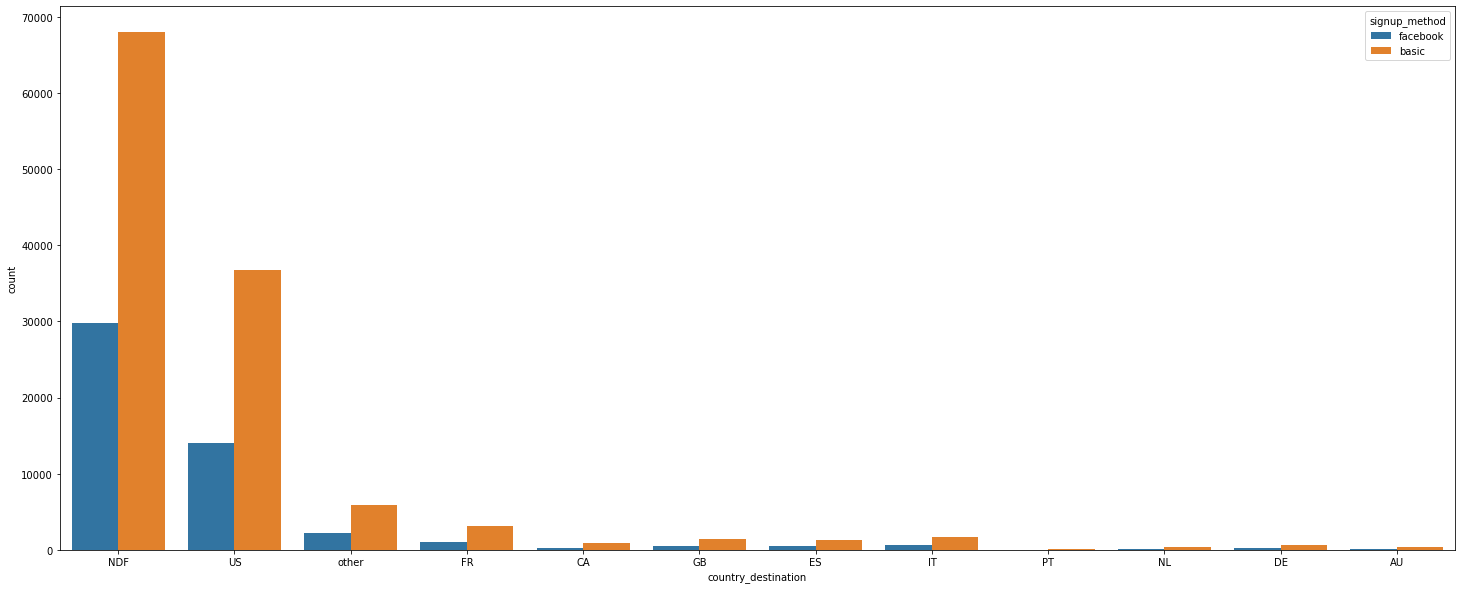

In [360]:
    print("There is no bias between signup_method and countryDestination");
    d1.countPlotWithHue("country_destination",'signup_method',dataset.trainDf);

There is no bias between signup app and country destination


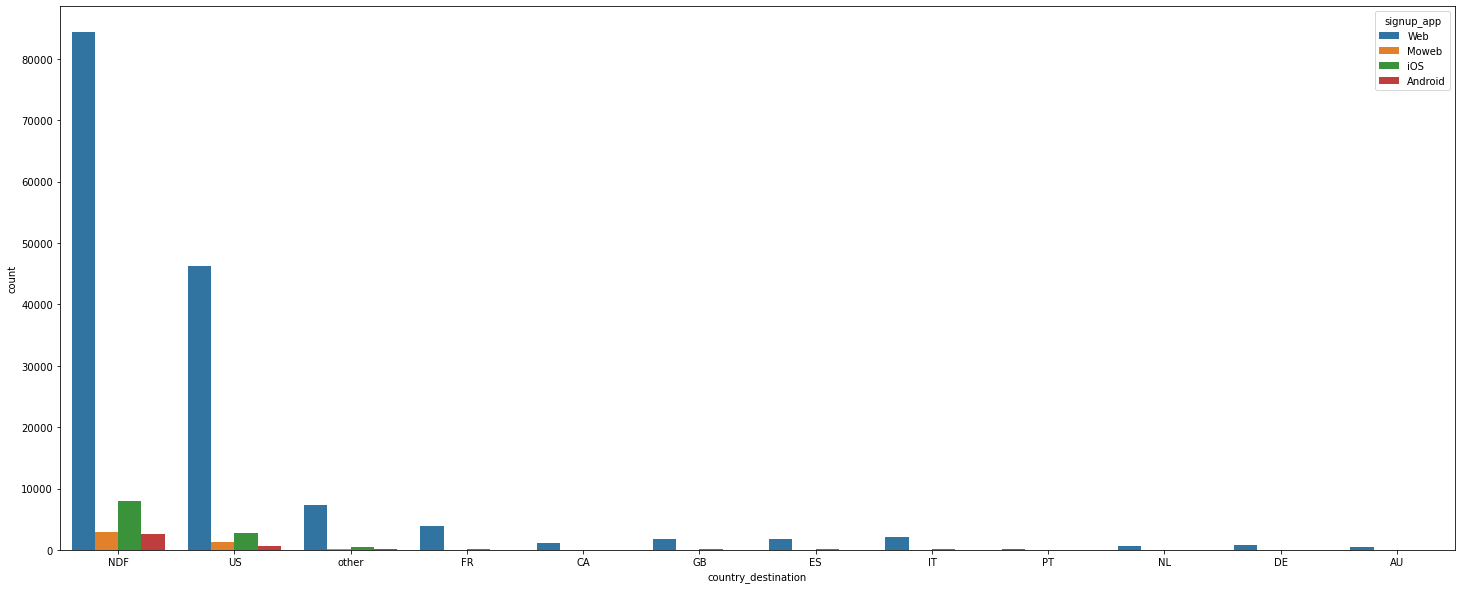

In [361]:
    print("There is no bias between signup app and country destination");
    d1.countPlotWithHue("country_destination",'signup_app',dataset.trainDf);

Here also we don't see any bias between device type and country destination


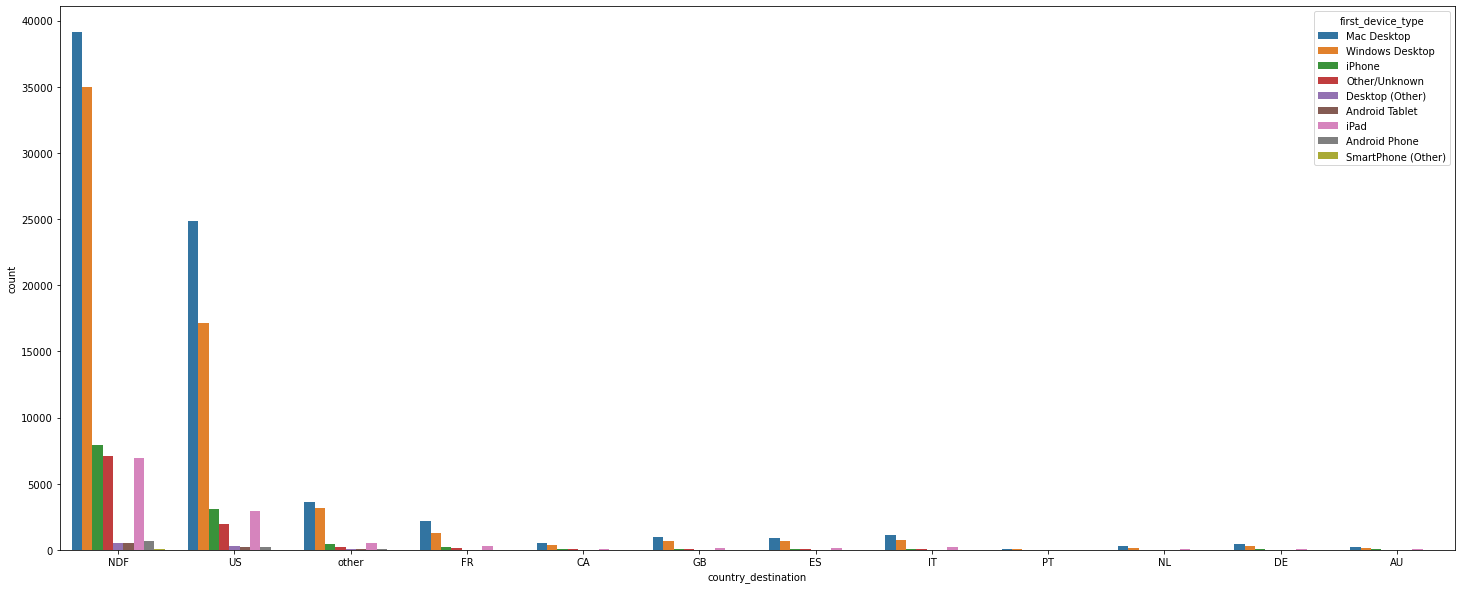

In [362]:
print("Here also we don't see any bias between device type and country destination");
d1.countPlotWithHue("country_destination",'first_device_type',dataset.trainDf);

Now let us analyze NDF relation with date_of_first_booking
Nothing special...should be intuitively correct to have no reds
SO WE GOT A WAY TO DIFFERENTIATE NDF


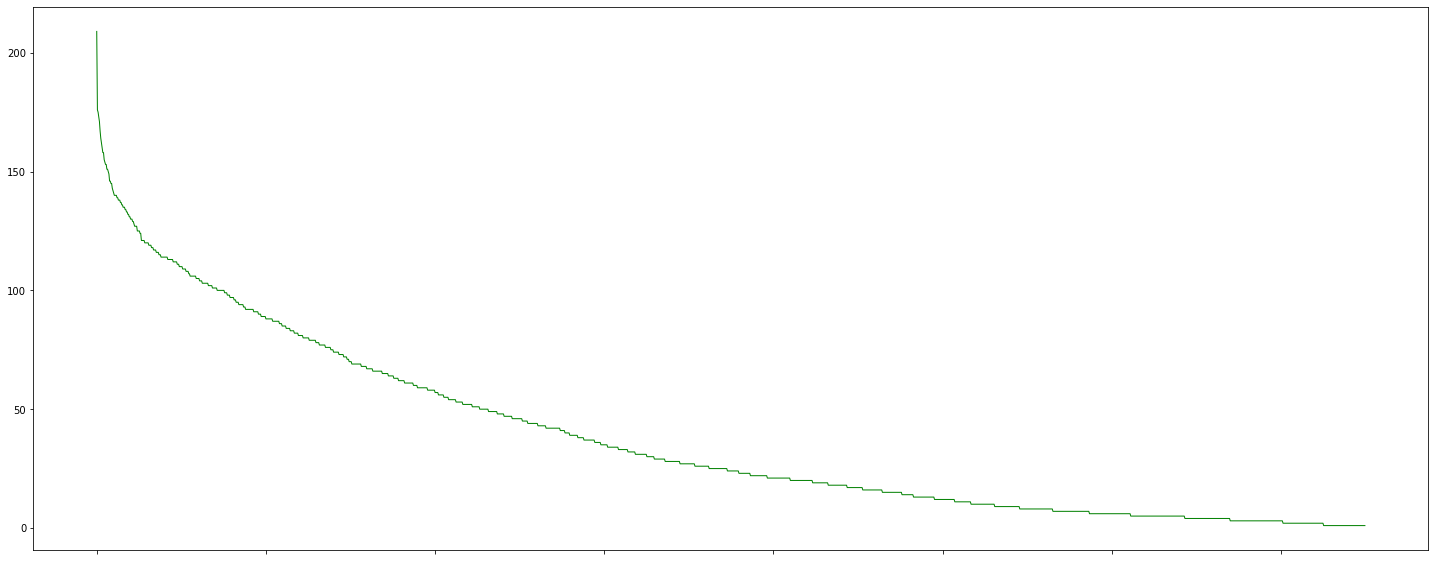

In [363]:
    print("Now let us analyze NDF relation with date_of_first_booking");
    analyzeNDF(dataset);
    print("Nothing special...should be intuitively correct to have no reds");
    print("SO WE GOT A WAY TO DIFFERENTIATE NDF");

In [364]:
    print("Lets do Feature Engineering");
    obj=majorFeatureEngg();
    #fe=featureEngineering(obj);
    featureEngineering(obj,dataset.trainDf);
    featureEngineering(obj,dataset.testDf);
    featureEngineering(obj,combineDB.allData);

Lets do Feature Engineering


In [365]:
    combine=combineDB.preprocess4(dataset);
    combineDB.preprocess5(combine);
    
    
    combineDB.preprocess6(dataset);
    combineDB.preprocess7(dataset);
    
    
    answers=combineDB.preprocess8(dataset);
    
    
    col=combineDB.preprocess9(dataset);
    combineDB.preprocess10(combine,col);
    
    
    ENCODING(dataset,col,combineDB.allData)

The shapes are  (170137, 14)   (43314, 14)
The shapes are  (170137, 26)   (43314, 26)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [366]:
    dataset.trainDf['age']=standardScalar(dataset.trainDf,'age');
    dataset.testDf['age']=standardScalar(dataset.testDf,'age');

# The Z-transform plots of age are

The age distribution plot for train set is 


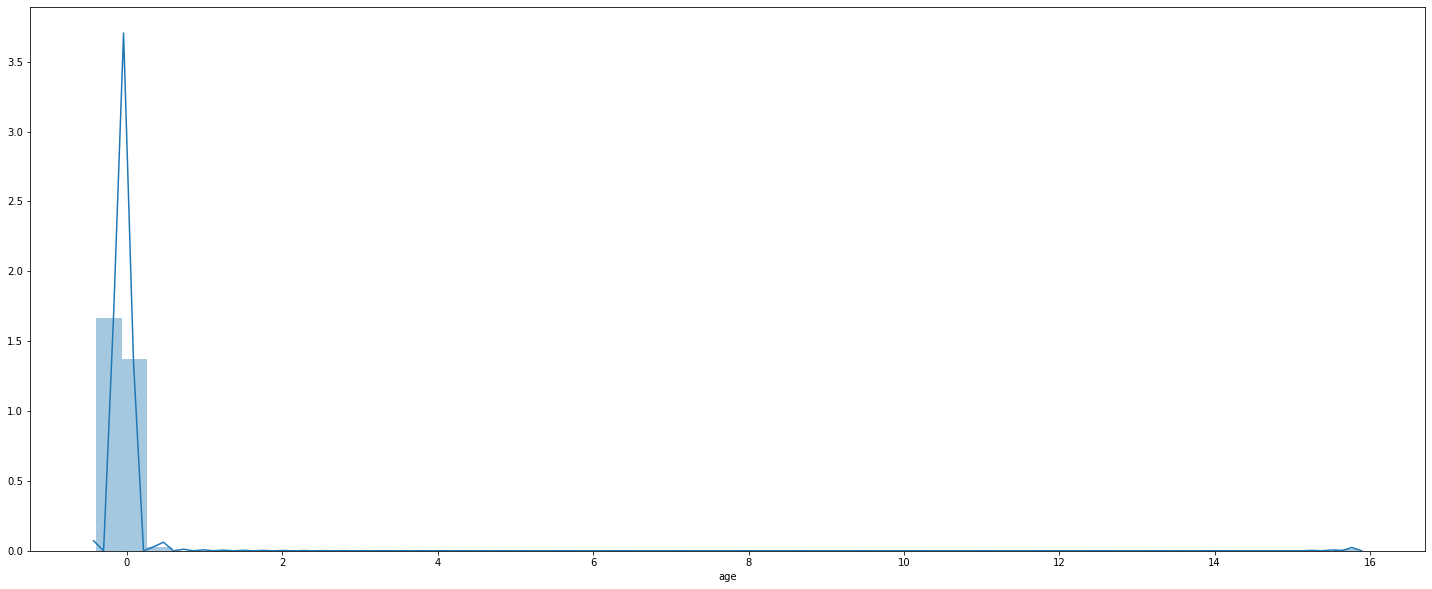

In [367]:
print("The age distribution plot for train set is ")
d1.distPlotNoCond(dataset.trainDf,'age');

The age distribution plot for test set is 


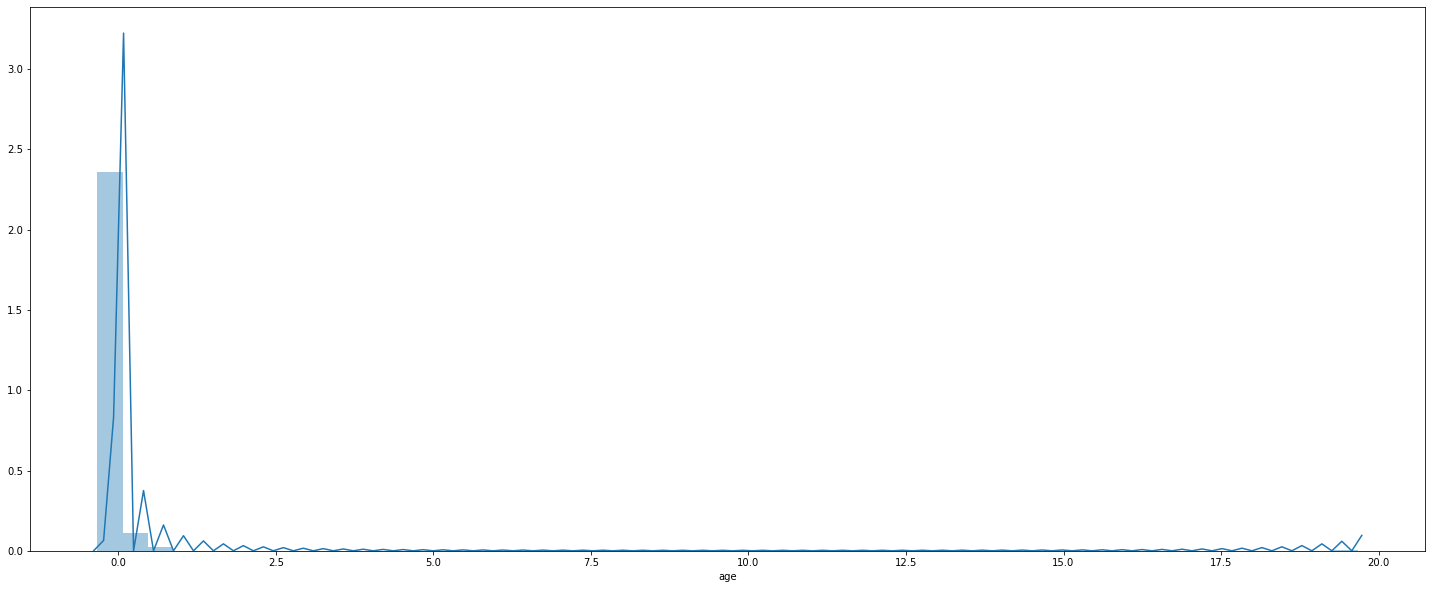

In [368]:
print("The age distribution plot for test set is ")
d1.distPlotNoCond(dataset.testDf,'age');